# HMI PINN

## Create

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

from zpinn.create_pot import get_potential_boundary
from zpinn.pinn_nf2_cleanup import create_coordinates, NF2Trainer

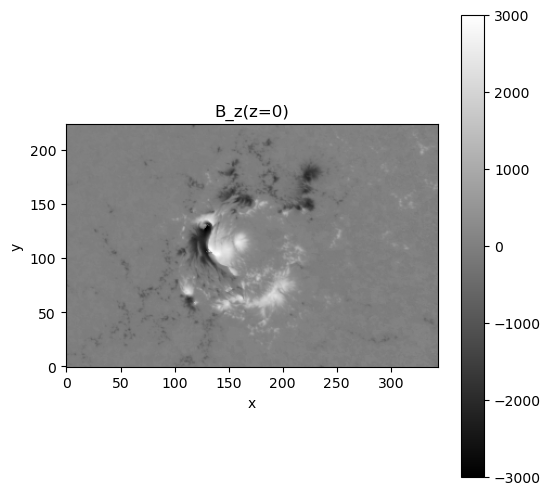

In [ ]:
input_path = '01_input/AR7115_20170906_090000/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [ ]:
output_path = '02_output/AR7115_20170906_090000/PINN'

Nx, Ny, _ = b_bottom.shape
Nz = 160

spatial_norm = 160
b_norm = 2500

In [ ]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)

boundary_npy_path = os.path.join(boundary_path, 'boundary_data.npy')

In [ ]:
total_iterations = 2000
log_interval = 100

num_neurons = 256
num_layers = 8

w_ff = 1
w_div = 1
w_bc_init = 1000
decay_iterations = 25000

lr_init = 5e-4
lr_final = 5e-5
lr_decay_iterations = 50000

batch_size = 10000
num_worker = 2

## Create boundary data

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)

coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

for i in range(len(coords)):
    coords[i] = np.reshape(coords[i], (-1, 3))
    fields[i] = np.reshape(fields[i], (-1, 3))

top_lateral_values = np.concatenate(fields) 
top_lateral_coords = np.concatenate(coords)

boundary_values = np.concatenate([top_lateral_values, bottom_values])
boundary_coords = np.concatenate([top_lateral_coords, bottom_coords])

normalized_boundary_values = boundary_values / b_norm
normalized_boundary_coords = boundary_coords / spatial_norm

boundary_data = np.stack([normalized_boundary_coords, normalized_boundary_values], 1)

with open(boundary_npy_path, 'wb') as f:
        np.save(f, boundary_data)

Potential Field: 100%|██████████| 380/380 [00:45<00:00,  8.38it/s]


## PINN

In [ ]:
torch.set_num_threads(num_worker)

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = np.load(f)

In [ ]:
trainer = NF2Trainer(output_path, b_bottom, height=Nz, b_norm=b_norm, spatial_norm=spatial_norm, meta_info=None, boundary_data=boundary_data)

In [ ]:
trainer.setup(total_iterations=total_iterations, batch_size=batch_size, log_interval=log_interval, num_workers=num_worker,
              num_neurons=num_neurons, num_layers=num_layers, w_ff=w_ff, w_div=w_div, w_bc_init=w_bc_init, decay_iterations=decay_iterations,
              lr_init=lr_init, lr_final=lr_final, lr_decay_iterations=lr_decay_iterations)

In [ ]:
start = time.time()

trainer.train()

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec')

Training:   0%|          | 1/2000 [00:01<39:11,  1.18s/it]

[Iteration 000000/002000] [loss: 15.52846718] [loss_bc: 15.52846622; loss_div: 0.00000053; loss_ff: 0.00000028] [w_bc: 1000.000000, LR: 0.000500]


Training:   5%|▌         | 100/2000 [00:34<10:53,  2.91it/s]

[Iteration 000100/002000] [loss: 8.61950684] [loss_bc: 8.61932087; loss_div: 0.00013437; loss_ff: 0.00005182] [w_bc: 973.016041, LR: 0.000498]


Training:  10%|█         | 200/2000 [01:07<09:49,  3.05it/s]

[Iteration 000200/002000] [loss: 8.52751255] [loss_bc: 8.52547169; loss_div: 0.00107037; loss_ff: 0.00097098] [w_bc: 946.498652, LR: 0.000495]


Training:  15%|█▌        | 300/2000 [01:40<09:44,  2.91it/s]

[Iteration 000300/002000] [loss: 7.72661066] [loss_bc: 7.72012520; loss_div: 0.00313696; loss_ff: 0.00334853] [w_bc: 920.703937, LR: 0.000493]


Training:  20%|██        | 400/2000 [02:14<08:48,  3.03it/s]

[Iteration 000400/002000] [loss: 7.84972239] [loss_bc: 7.84066534; loss_div: 0.00615787; loss_ff: 0.00289916] [w_bc: 895.612198, LR: 0.000491]


Training:  25%|██▌       | 500/2000 [02:47<08:08,  3.07it/s]

[Iteration 000500/002000] [loss: 8.47111797] [loss_bc: 8.45317078; loss_div: 0.01254979; loss_ff: 0.00539777] [w_bc: 871.204279, LR: 0.000489]


Training:  30%|███       | 600/2000 [03:20<08:05,  2.88it/s]

[Iteration 000600/002000] [loss: 6.58087587] [loss_bc: 6.55720186; loss_div: 0.01745168; loss_ff: 0.00622205] [w_bc: 847.461544, LR: 0.000486]


Training:  35%|███▌      | 700/2000 [03:53<06:49,  3.18it/s]

[Iteration 000700/002000] [loss: 6.67149734] [loss_bc: 6.64559650; loss_div: 0.01850222; loss_ff: 0.00739858] [w_bc: 824.365864, LR: 0.000484]


Training:  40%|████      | 800/2000 [04:26<06:33,  3.05it/s]

[Iteration 000800/002000] [loss: 7.89865828] [loss_bc: 7.86588335; loss_div: 0.02329697; loss_ff: 0.00947827] [w_bc: 801.899606, LR: 0.000482]


Training:  45%|████▌     | 900/2000 [04:59<06:10,  2.97it/s]

[Iteration 000900/002000] [loss: 6.43574619] [loss_bc: 6.38530445; loss_div: 0.03725624; loss_ff: 0.01318558] [w_bc: 780.045615, LR: 0.000480]


Training:  50%|█████     | 1000/2000 [05:32<05:36,  2.97it/s]

[Iteration 001000/002000] [loss: 5.18774605] [loss_bc: 5.11482286; loss_div: 0.04803484; loss_ff: 0.02488867] [w_bc: 758.787207, LR: 0.000478]


Training:  55%|█████▌    | 1100/2000 [06:06<05:01,  2.98it/s]

[Iteration 001100/002000] [loss: 5.08402014] [loss_bc: 4.97362185; loss_div: 0.06738125; loss_ff: 0.04301701] [w_bc: 738.108149, LR: 0.000475]


Training:  60%|██████    | 1200/2000 [06:38<04:12,  3.17it/s]

[Iteration 001200/002000] [loss: 4.21153545] [loss_bc: 4.03686905; loss_div: 0.11213142; loss_ff: 0.06253481] [w_bc: 717.992653, LR: 0.000473]


Training:  65%|██████▌   | 1300/2000 [07:11<04:05,  2.85it/s]

[Iteration 001300/002000] [loss: 3.71575952] [loss_bc: 3.55564880; loss_div: 0.09888729; loss_ff: 0.06122358] [w_bc: 698.425359, LR: 0.000471]


Training:  70%|███████   | 1400/2000 [07:44<03:19,  3.01it/s]

[Iteration 001400/002000] [loss: 3.72195458] [loss_bc: 3.47767830; loss_div: 0.16611616; loss_ff: 0.07816005] [w_bc: 679.391329, LR: 0.000469]


Training:  75%|███████▌  | 1500/2000 [08:16<02:54,  2.86it/s]

[Iteration 001500/002000] [loss: 3.43064690] [loss_bc: 3.25850749; loss_div: 0.11048775; loss_ff: 0.06165172] [w_bc: 660.876030, LR: 0.000467]


Training:  80%|████████  | 1600/2000 [08:49<02:06,  3.16it/s]

[Iteration 001600/002000] [loss: 3.19253063] [loss_bc: 2.98674703; loss_div: 0.13137031; loss_ff: 0.07441322] [w_bc: 642.865323, LR: 0.000465]


Training:  85%|████████▌ | 1700/2000 [09:22<01:35,  3.15it/s]

[Iteration 001700/002000] [loss: 3.42698693] [loss_bc: 3.25930786; loss_div: 0.11005400; loss_ff: 0.05762512] [w_bc: 625.345458, LR: 0.000462]


Training:  90%|█████████ | 1800/2000 [09:55<01:06,  3.02it/s]

[Iteration 001800/002000] [loss: 3.10764647] [loss_bc: 2.95921421; loss_div: 0.09836961; loss_ff: 0.05006265] [w_bc: 608.303058, LR: 0.000460]


Training:  95%|█████████▌| 1900/2000 [10:27<00:32,  3.07it/s]

[Iteration 001900/002000] [loss: 3.18695903] [loss_bc: 3.00165105; loss_div: 0.12308557; loss_ff: 0.06222259] [w_bc: 591.725111, LR: 0.000458]


Training: 100%|██████████| 2000/2000 [11:00<00:00,  3.03it/s]

[Iteration 002000/002000] [loss: 2.65316772] [loss_bc: 2.48987842; loss_div: 0.11366164; loss_ff: 0.04962770] [w_bc: 575.598959, LR: 0.000456]
[Iteration 002000/002000] [loss: 2.65316772] [loss_bc: 2.48919082; loss_div: 0.11366164; loss_ff: 0.04962770] [w_bc: 575.439937, LR: 0.000456]
Runtime --> total: 660.73sec


## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/AR7115_20170906_090000/PINN'
vtk_path = os.path.join(eval_path, 'B_pinn.vtk')

### vtk

In [ ]:
save_path = os.path.join(output_path, 'model_%06d.pt' % total_iterations)
pinn = pinn_cube(save_path)
pinn.calculate_magnetic_fields(batch_size=batch_size)

100%|██████████| 1233/1233 [00:04<00:00, 255.16it/s]


ImageData (0x7fa43af06560)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
pinn.state

{'iteration': 2000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0-7): 8 x Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (344, 224, 160),
 'b_norm': 2500,
 'spatial_norm': 160,
 'loss_bc': array(0.00432572, dtype=float32),
 'w_bc': 575.4399373371799,
 'loss_div': array(0.0496277, dtype=float32),
 'w_div': 1,
 'loss_ff': array(0.11366164, dtype=float32),
 'w_ff': 1,
 'LR': 0.0004560054196779496}

In [ ]:
pinn.grid.save(vtk_path)

### load

In [ ]:
B_pinn_mesh = pv.read(vtk_path)

In [ ]:
B_pinn_grid = draw_grid(B_pinn_mesh)

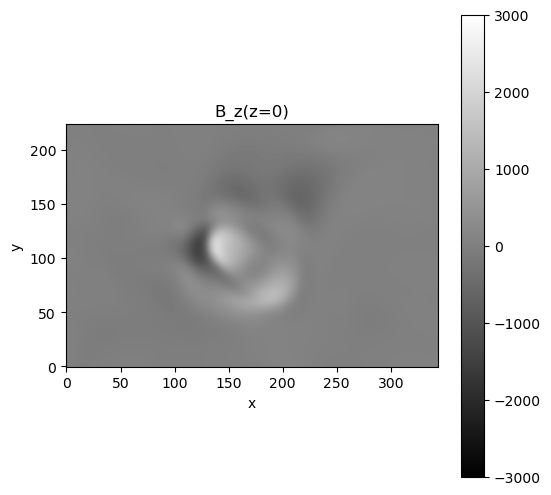

In [ ]:
B_pinn_grid.plt_Bz_imshow(z=0, vmin=-3000, vmax=3000)

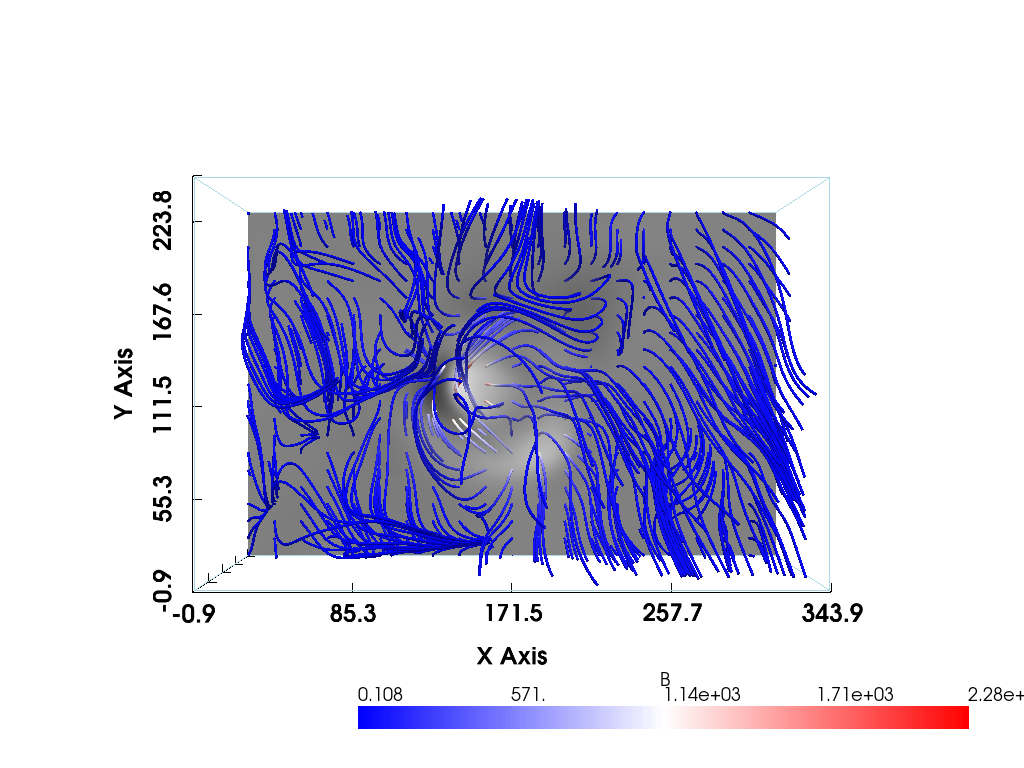

In [ ]:
B_pinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=20, j_resolution=20, vmin=-3000, vmax=3000)

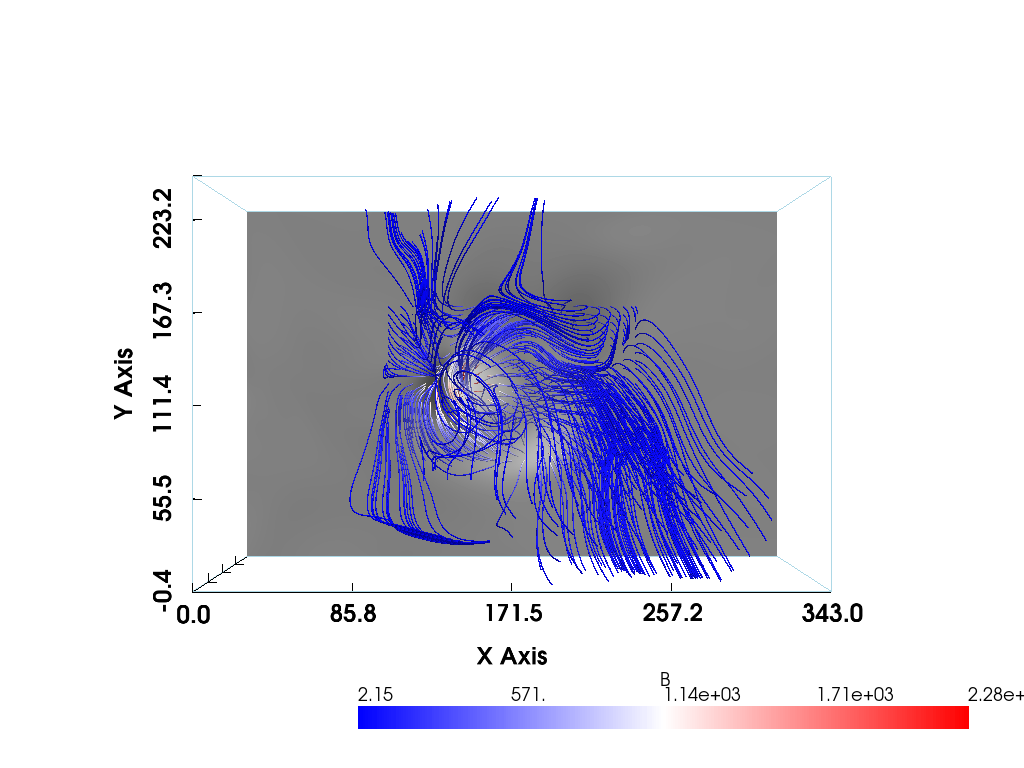

In [ ]:
B_pinn_grid.pv_streamline_Bz(camera_position='xy', i_siz=160, j_siz=100, i_resolution=20, j_resolution=20, vmin=-3000, vmax=3000)